In [1]:
import glob
import numpy
import pandas
import seaborn
import matplotlib.pyplot as plt
from tqdm import tqdm
import multiprocessing as mp
import os
from build import build_model
import coralme
plt.rcParams['svg.fonttype'] = 'none'


In [2]:
from IPython.display import display, HTML, Math, Markdown
display(HTML("<style>.container { width:95% !important; }</style>"))

%load_ext autoreload
%autoreload 2

### Plot as boxplot

In [3]:
tmp = pandas.read_csv("./datasets/2.3.1.all_growth_rates_fold_change_Strain.csv",index_col=0)
taxonomy = pandas.read_csv("./taxonomy.txt",index_col=0,sep='\t')
taxonomy = taxonomy[taxonomy["Kingdom"]=="Bacteria"]

In [4]:
# tmp = tmp.drop("mid_zinc",axis=1)
tmp = tmp[[i for i in tmp.columns if i not in taxonomy.columns]]

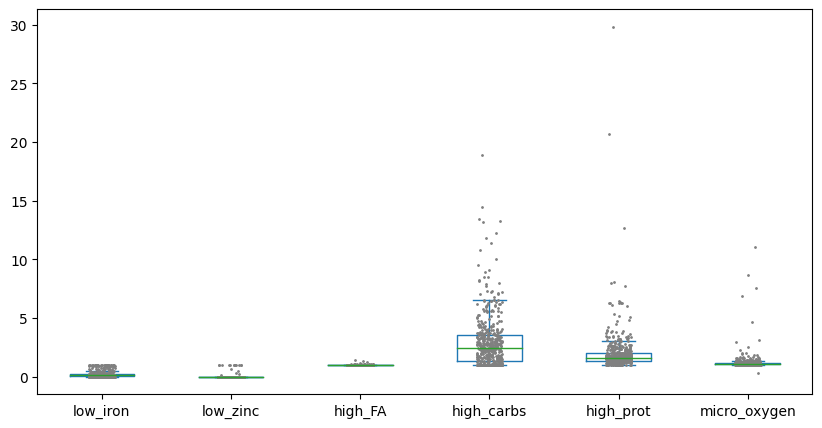

In [5]:
import random
fig,ax = plt.subplots(1,1,figsize=(10,5))
tmp.plot.box(showfliers=False,ax=ax)
for x in range(len(tmp.columns)):
    for val in tmp[tmp.columns[x]].values:
        ax.plot(x+1 + random.uniform(-1, 1)/10, val,'o',color='gray',markersize=1)

### Plot as boxplot/histogram

In [6]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats


def plot_dots(ax,values):
    for val in values:
        ax.plot(val,random.uniform(-1, 1)/5,'o',color='black',markersize=1,alpha=0.2)

def get_distbox(col):
    x = tmp[col].values
    sns.set(style="ticks")
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
                                        gridspec_kw={"height_ratios": (.15, .85)},
                                       figsize=(5,2))

    flierprops = dict(marker='+', markersize=5)
    sns.boxplot(x, ax=ax_box, orient="h",showfliers=True,flierprops=flierprops)
    # plot_dots(ax_box,x)
    sns.histplot(x, ax=ax_hist,bins=15,kde=True)

    gamma = get_gamma(x)
    # data = gamma.rvs(size=len(x))
    conf = 0.05
    low,high = gamma.ppf(conf),gamma.ppf(1-conf)
    # ax_hist.axvline(x=low,ymin=0.,ymax=200.)
    ax_hist.axvline(x=high,ymin=0.,ymax=200.)
    
    ax_box.set(yticks=[])
    ax_box.set_title(col)
    ax_hist.set_xlim(left=0)
    sns.despine(ax=ax_hist)
    sns.despine(ax=ax_box, left=True, bottom=True)
    return low,high

def get_gamma(x):
    fit_alpha, fit_loc, fit_beta=stats.gamma.fit(x)
    return stats.gamma(a=fit_alpha, loc=fit_loc, scale=fit_beta)

def get_slices(col,bounds):
    low = taxonomy.reset_index().set_index("Strain").loc[tmp[tmp[col]<bounds[0]].index][taxa]
    high = taxonomy.reset_index().set_index("Strain").loc[tmp[tmp[col]>bounds[1]].index][taxa]
    return low,high

def get_enrichment(slice,reference):
    tmp1 = slice.value_counts()
    tmp1 = tmp1/tmp1.sum()
    tmp2 = reference.value_counts()
    tmp2 = tmp2/tmp2.sum()
    return tmp1.div(tmp2).dropna(0).sort_values(ascending=False)
    
def plot_pies(slices):
    fig,ax = plt.subplots(1,2,figsize=(13,5))
    low,high = slices
    low.value_counts().plot.pie(ax=ax[0])
    high.value_counts().plot.pie(ax=ax[1])
    ax[0].set_title("Low ({})".format(low.shape[0]))
    ax[1].set_title("High ({})".format(high.shape[0]))

def plot(col):
    bounds = get_distbox(col)
    slices = get_slices(col,bounds)
    slice = slices[0] if tail == "low" else slices[1]
    enrichment = get_enrichment(slice,taxonomy[taxa])
    # fig,ax = plt.subplots(1,1,figsize=(5,enrichment.shape[0]*0.2))
    # np.log2(enrichment).plot.barh(ax=ax)
    enrichment_dct[col] = enrichment
    plt.savefig("./figures/2.3.1.{}_diet_effect_distribution.svg".format(col),format="SVG")

In [7]:
taxa = "Genus"
tail = "high"

/tmp/ipykernel_942047/2894343315.py:51: FutureWarning: In a future version of pandas all arguments of Series.dropna will be keyword-only.
  return tmp1.div(tmp2).dropna(0).sort_values(ascending=False)
/tmp/ipykernel_942047/2894343315.py:51: FutureWarning: In a future version of pandas all arguments of Series.dropna will be keyword-only.
  return tmp1.div(tmp2).dropna(0).sort_values(ascending=False)
/tmp/ipykernel_942047/2894343315.py:51: FutureWarning: In a future version of pandas all arguments of Series.dropna will be keyword-only.
  return tmp1.div(tmp2).dropna(0).sort_values(ascending=False)
/tmp/ipykernel_942047/2894343315.py:51: FutureWarning: In a future version of pandas all arguments of Series.dropna will be keyword-only.
  return tmp1.div(tmp2).dropna(0).sort_values(ascending=False)
/tmp/ipykernel_942047/2894343315.py:51: FutureWarning: In a future version of pandas all arguments of Series.dropna will be keyword-only.
  return tmp1.div(tmp2).dropna(0).sort_values(ascending=Fa

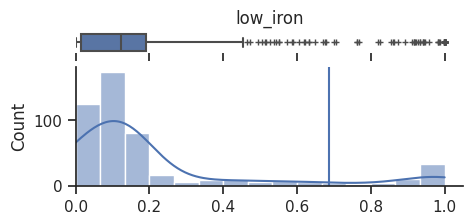

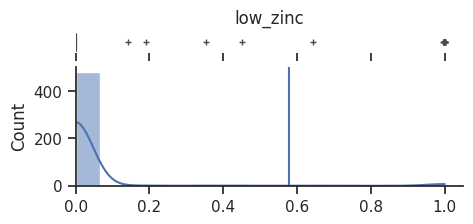

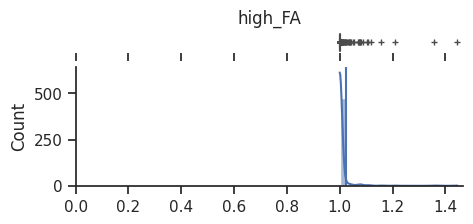

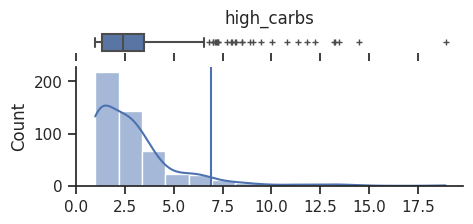

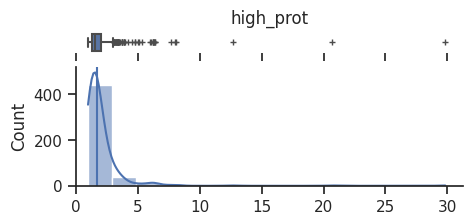

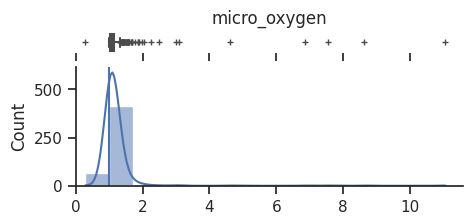

In [8]:
enrichment_dct = {}
for col in tmp.columns:
    plot(col)
df = pandas.DataFrame.from_dict(enrichment_dct).T

/tmp/ipykernel_942047/913932558.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdBu_r').copy()


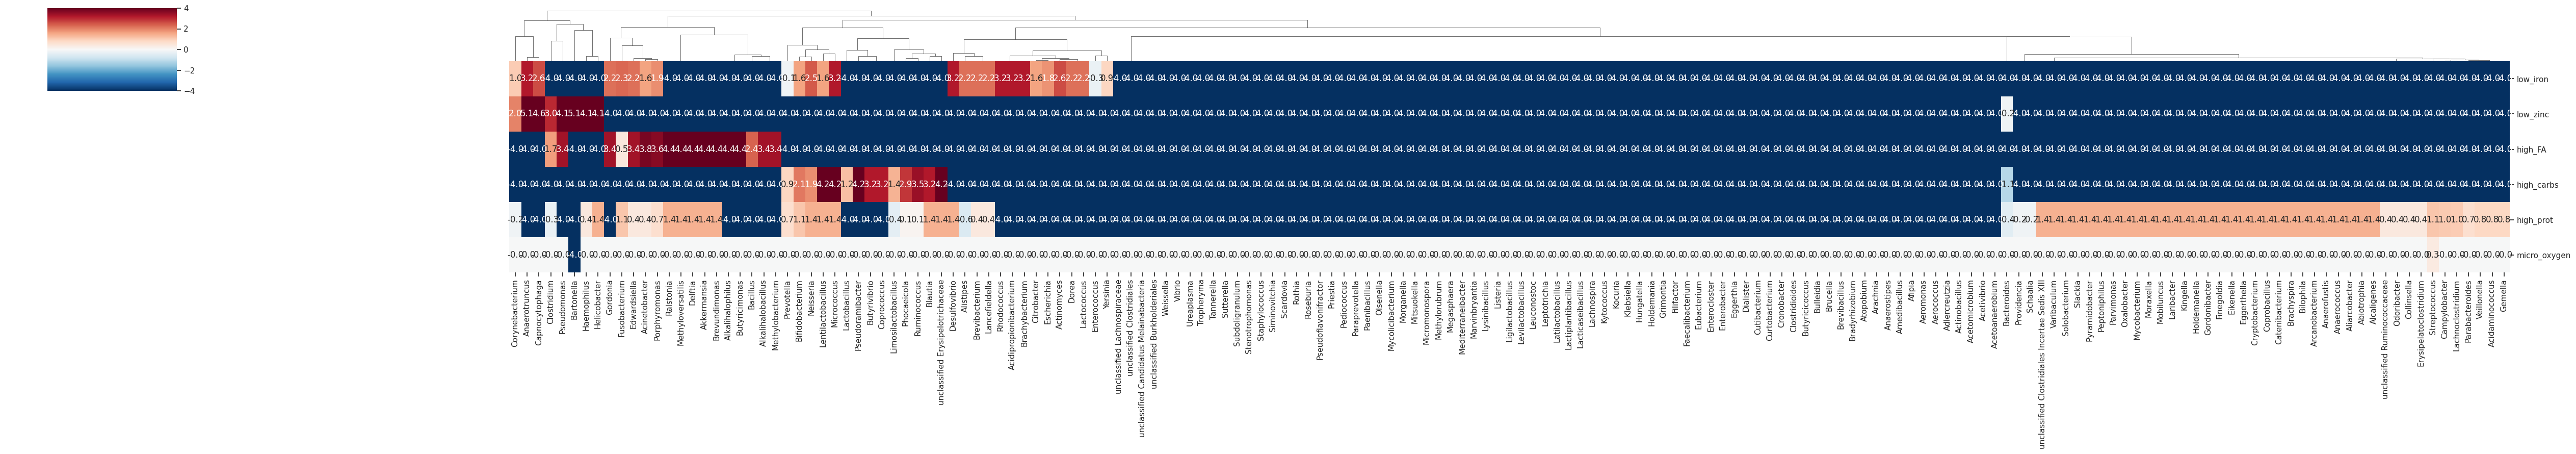

In [9]:
import seaborn as sns
cmap = plt.cm.get_cmap('RdBu_r').copy()
# cmap.set_under('white')
vmin,vmax = (-4,4)
cmap_df = np.log2(df).fillna(vmin)
# cmap_df = df.fillna(0)
cmap = sns.clustermap(cmap_df,
               row_cluster=False,
               col_cluster=True,
               vmin=vmin,
               vmax=vmax,
               annot=True,
               fmt=".1f",
               cmap=cmap,
               # annot_kws={'rotation': 90}
               figsize=(0.3*cmap_df.shape[1],(1.5)*cmap_df.shape[0]),
               # cbar=False,
              )
labels = [i.get_text() for i in cmap.ax_heatmap.xaxis.get_majorticklabels()]
# cmap.ax_heatmap.set_xticklabels(cmap.ax_heatmap.get_xticklabels(), rotation=90)
# _=plt.setp(cmap.ax_heatmap.get_xticklabels(), rotation=80)
# plt.savefig("./figures/diets_growth_rate_clustermap.svg",format="SVG")

/tmp/ipykernel_942047/2826315258.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdBu_r').copy()


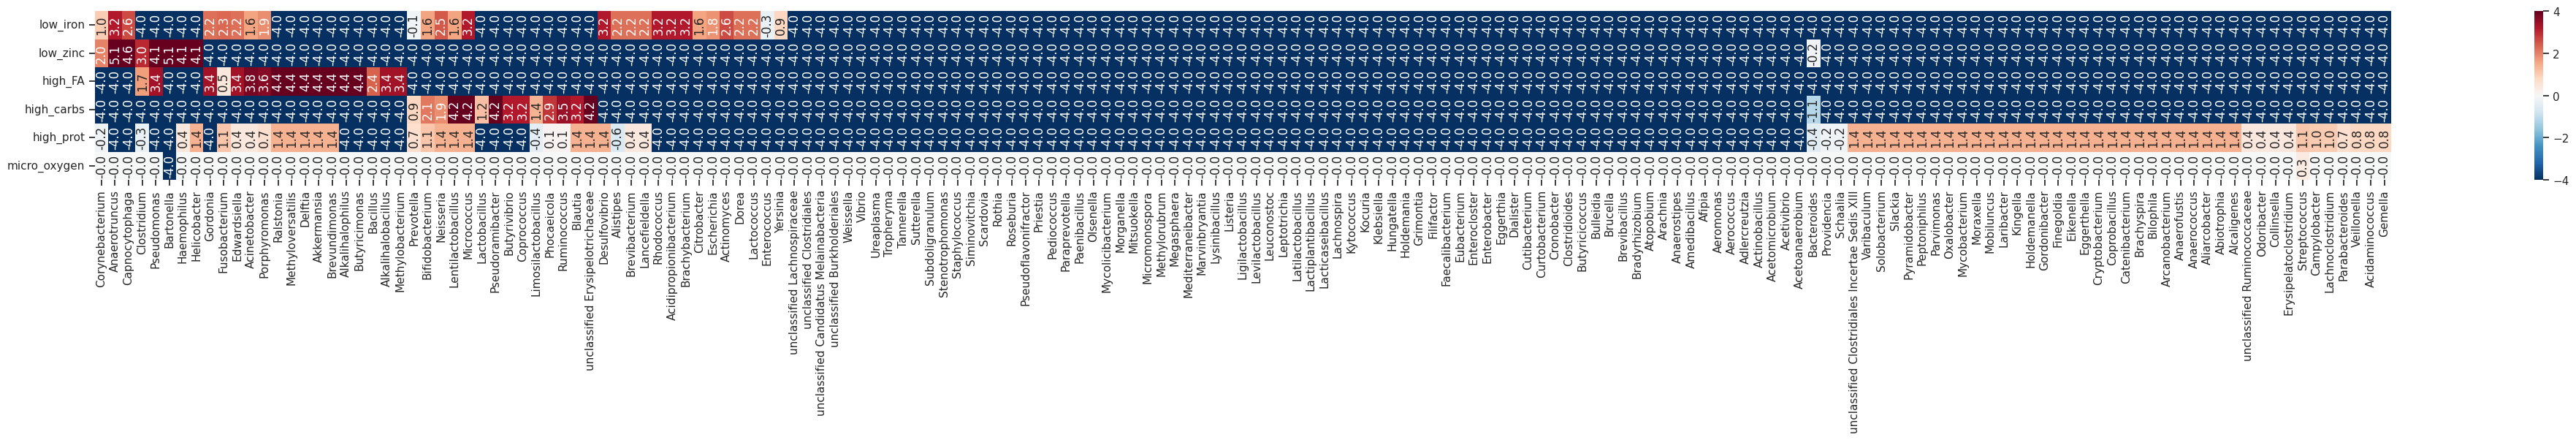

In [10]:
import seaborn as sns
fig,ax = plt.subplots(1,1, figsize=(0.3*df.shape[1],(0.5)*df.shape[0]))
cmap = plt.cm.get_cmap('RdBu_r').copy()
# cmap.set_under('white')
cmap = sns.heatmap(cmap_df[labels],
               vmin=vmin,
               vmax=vmax,
               annot=True,
               fmt=".1f",
               cmap=cmap,
               annot_kws={'rotation': 90}
               # figsize=(0.3*df.shape[1],(1.5)*df.shape[0]),
               # cbar=False,
              )
# cmap.ax_heatmap.set_xticklabels(cmap.ax_heatmap.get_xticklabels(), rotation=90)
# _=plt.setp(cmap.ax_heatmap.get_xticklabels(), rotation=80)

plt.savefig("./figures/diets_growth_rate_heatmap.svg",format="SVG")

In [11]:
cmap_df[labels].T.to_csv("./datasets/2.3.1.{}_gamma_tail_scores.csv".format(tail))

In [12]:
cmap_df

,Abiotrophia,Acetivibrio,Acetoanaerobium,Acetomicrobium,Acidaminococcus,Acidipropionibacterium,Acinetobacter,Actinobacillus,Actinomyces,Adlercreutzia,...,Vibrio,Weissella,Yersinia,unclassified Burkholderiales,unclassified Candidatus Melainabacteria,unclassified Clostridiales,unclassified Clostridiales Incertae Sedis XIII,unclassified Erysipelotrichaceae,unclassified Lachnospiraceae,unclassified Ruminococcaceae
low_iron,-4.000000,-4.0000,-4.0000,-4.0000,-4.000000,3.196397,1.611435,-4.0000,2.611435,-4.0000,...,-4.0000,-4.0000,0.874469,-4.0000,-4.0000,-4.0000,-4.000000,-4.000000,-4.0000,-4.000000
low_zinc,-4.000000,-4.0000,-4.0000,-4.0000,-4.000000,-4.000000,-4.000000,-4.0000,-4.000000,-4.0000,...,-4.0000,-4.0000,-4.000000,-4.0000,-4.0000,-4.0000,-4.000000,-4.000000,-4.0000,-4.000000
high_FA,-4.000000,-4.0000,-4.0000,-4.0000,-4.000000,-4.000000,3.781360,-4.0000,-4.000000,-4.0000,...,-4.0000,-4.0000,-4.000000,-4.0000,-4.0000,-4.0000,-4.000000,-4.000000,-4.0000,-4.000000
high_carbs,-4.000000,-4.0000,-4.0000,-4.0000,-4.000000,-4.000000,-4.000000,-4.0000,-4.000000,-4.0000,...,-4.0000,-4.0000,-4.000000,-4.0000,-4.0000,-4.0000,-4.000000,4.196397,-4.0000,-4.000000
high_prot,1.419903,-4.0000,-4.0000,-4.0000,0.834941,-4.000000,0.419903,-4.0000,-4.000000,-4.0000,...,-4.0000,-4.0000,-4.000000,-4.0000,-4.0000,-4.0000,1.419903,1.419903,-4.0000,0.419903
micro_oxygen,-0.014500,-0.0145,-0.0145,-0.0145,-0.014500,-0.014500,-0.014500,-0.0145,-0.014500,-0.0145,...,-0.0145,-0.0145,-0.014500,-0.0145,-0.0145,-0.0145,-0.014500,-0.014500,-0.0145,-0.014500
